In [102]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(df_ts_cohort,label='Train')
    plt.plot(df_ts_cohort, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    


# Detect Discrete Anomalies

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True) # replace the brackets with empty string
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) # replace the first instance of this
df = df.set_index('timestamp')

In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '') # replace quotes with nothing

# replace the question mark and the page plus page numbers
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']] #normalizes the size column?

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1%
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,95.31.16.121,1,0.000072
10,52.91.30.150,1,0.000072
11,45.23.250.16,1,0.000072
12,97.105.15.120,1,0.000072
13,34.229.70.250,1,0.000072


22
               ip  ip_count  ip_proba
12  97.105.15.120         1  0.000072
13  34.229.70.250         1  0.000072
14  34.207.64.242         1  0.000072
15   3.92.201.136         1  0.000072
16  52.90.165.200         1  0.000072
17   95.31.18.119         1  0.000072
18  54.172.14.223         1  0.000072
19   3.88.129.158         1  0.000072
20  54.145.52.184         1  0.000072
21   35.174.209.2         1  0.000072


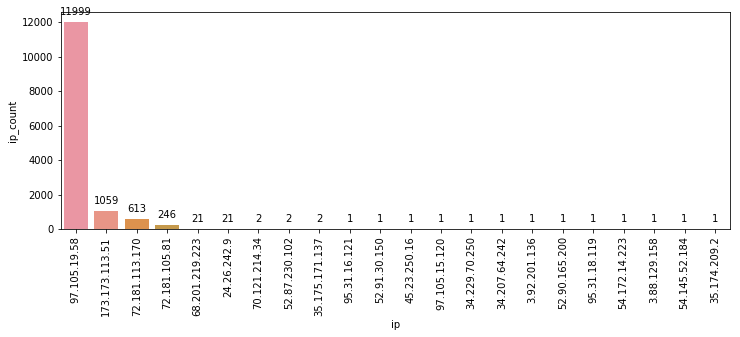

In [10]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives

In [11]:
# Establish baseline
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method', 'status', 'size', 'destination', 'request_agent', 'size_mb']]


In [12]:
# Compute probabilities based on train sample
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index':'ip', 'ip': 'ip_proba'})

In [13]:
# Merge probabilities with all data (train+new data)
# Where the ip address is new, i.e. not seen in the training dataset,
# fill the probability with a value of 0.
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

## Conditional Probabilities: probabilities using 2 discrete variables

In [14]:
#probabilities of Status given ip Address
# If we are looking for an unexpected status (like authentication failure) from a known/common ip address.

ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [15]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_agent'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_agent': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

In [16]:
# Add thes probabilities to original events to detect anomalous events

df = df.reset_index().merge(ip_status, on=['ip','status'],how='left').fillna(value=0).set_index('timestamp')

In [17]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


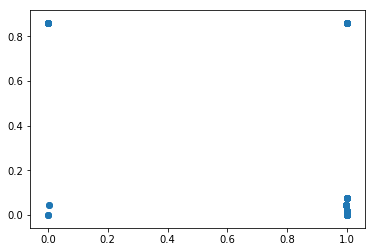

In [18]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)

# Detect Time Series Anomalies

In [19]:
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)
# data.columns = ["a", "b", "c", 'd', "etc."]

In [20]:
data.head(100)

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61
9,2018-01-26,09:58:26,javascript-i/functions,4,22.0,97.105.19.61


In [21]:
data['date'] = data[0].map(str) + ' ' + data[1]

In [22]:
data.head()

,0,1,2,3,4,5,date
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [23]:
type(data.date)

pandas.core.series.Series

In [24]:
data['date'] = pd.to_datetime(data.date)

In [25]:
data.head()

,0,1,2,3,4,5,date
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [26]:
data.dtypes

0               object
1               object
2               object
3                int64
4              float64
5               object
date    datetime64[ns]
dtype: object

In [27]:
data.set_index(data.date, inplace=True)

In [28]:
data.head(20)

,0,1,2,3,4,5,date
date,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24
2018-01-26 09:56:41,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,2018-01-26 09:56:41
2018-01-26 09:56:46,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,2018-01-26 09:56:46
2018-01-26 09:56:48,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61,2018-01-26 09:56:48
2018-01-26 09:56:59,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61,2018-01-26 09:56:59


In [29]:
data.columns

Index([0, 1, 2, 3, 4, 5, 'date'], dtype='object')

In [30]:
data = data.rename(columns={0: 'time1', 1: "time2", 2: 'link', 3: 'number1', 4: 'number2', 5: 'ip'})

In [31]:
data.head()

,time1,time2,link,number1,number2,ip,date
date,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [32]:
data = data.drop(['time1', 'time2'], axis=1)

In [33]:
data.head()

,link,number1,number2,ip,date
date,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [34]:
data = data.drop(['date'], axis=1)

In [35]:
data.head()

,link,number1,number2,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [36]:
data = data.rename(columns={'number2': 'cohort', 'number1':'user_id'})

In [37]:
data.head()

,link,user_id,cohort,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [38]:
data.isnull().sum()

link           0
user_id        0
cohort     14458
ip             0
dtype: int64

In [39]:
data.cohort.fillna(0, inplace=True)

In [40]:
data.isnull().sum()

link       0
user_id    0
cohort     0
ip         0
dtype: int64

In [54]:
df1 = data.where(data.cohort == 0)

In [56]:
df1 = df1.dropna()

In [57]:
df1.head()

,link,user_id,cohort,ip
date,,,,
2018-01-26 16:46:16,/,48.0,0.0,97.105.19.61
2018-01-26 16:46:24,spring/extra-features/form-validation,48.0,0.0,97.105.19.61
2018-01-26 17:54:24,/,48.0,0.0,97.105.19.61
2018-01-26 18:32:03,/,48.0,0.0,97.105.19.61
2018-01-26 18:32:17,mysql/relationships/joins,48.0,0.0,97.105.19.61


In [69]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_cohort = df1['cohort'].resample('W').count()

idx = pd.date_range(
    df_ts_cohort.sort_index().index.min(), 
    df_ts_cohort.sort_index().index.max(),
    freq='W'
)

df_ts_cohort = df_ts_cohort.reindex(idx, fill_value=0).fillna(value=0)



In [70]:
short_rolling = df_ts_cohort.rolling(window=12).mean()

In [71]:
long_rolling = df_ts_cohort.rolling(window=24).mean()

Text(0, 0.5, 'Size (MB)')

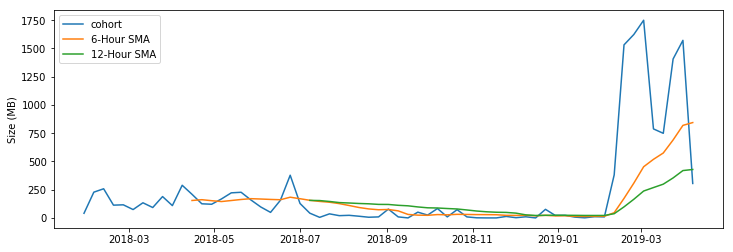

In [73]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_cohort.index, 
        df_ts_cohort,
        label='cohort')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

In [74]:
# Exponential Moving Average

In [76]:
ema_short = df_ts_cohort.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = df_ts_cohort.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2018-01-28    41.0000
2018-02-04    55.9600
2018-02-11    72.1232
Freq: W-SUN, Name: cohort, dtype: float64

In [80]:
span = 24
ema_long = df_ts_cohort.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

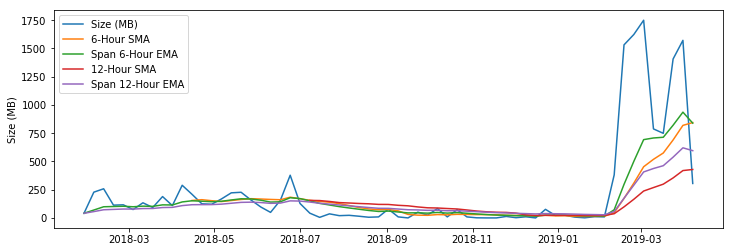

In [86]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_cohort.index, 
        df_ts_cohort,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=df_ts_cohort))

In [87]:
span = 24
ema_long = df_ts_cohort.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

In [88]:
# compute the %%b for each record

In [89]:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

In [93]:
yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [94]:
# Extract the anomalies

In [97]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-02-17,1532,595.37489,936.62511,1.304553
2019-02-24,1624,595.37489,1028.62511,1.383581
2019-03-03,1750,595.37489,1154.62511,1.491814
2019-03-24,1407,595.37489,811.62511,1.197179
2019-03-31,1572,595.37489,976.62511,1.338913


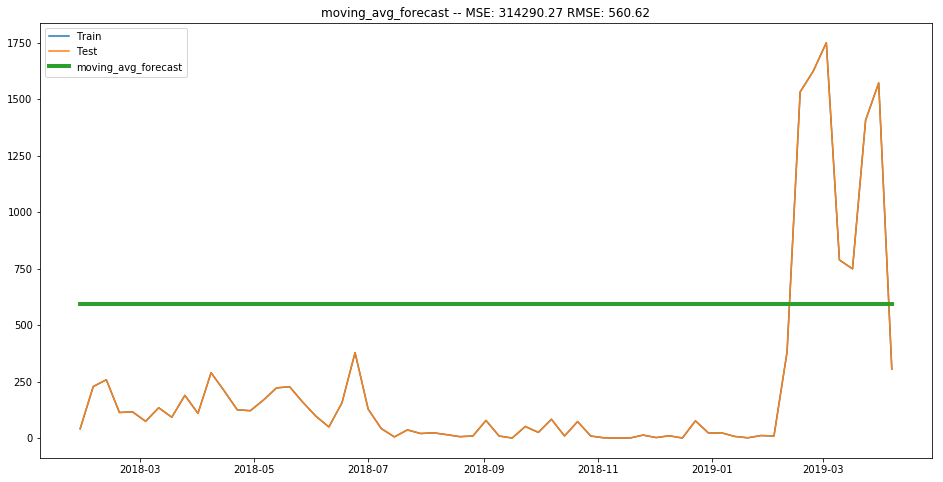

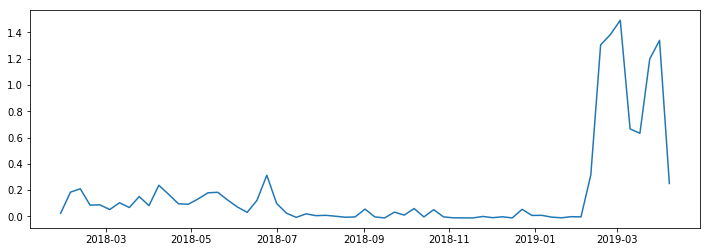

In [103]:
plot_and_eval(yhat.moving_avg_forecast, actual=df_ts_cohort)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Clustering - DBSCAN